# Demographcis of the NSRR training/testing sets

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
sns.set(style="ticks", font_scale=1.25)

from helper_functions import mean_std

# Define paths
wdir_demo = "output/demo/"
outdir = "output/plots/"

## Data loading

In [2]:
# First, let's merge with the main demographics
df_demo = pd.read_csv(wdir_demo + "demo_nsrr_all.csv")

print(df_demo.shape)
print(df_demo['set'].value_counts())
df_demo.head()

(3881, 13)
training    3281
testing      600
Name: set, dtype: int64


,dataset,subj,age,male,bmi,ahi,ethnicity,set,depression,diabete,hypertension,insomnia,narcolepsy
0,CCSHS,1800001,17,0,19.089716,0.244898,caucasian,training,0.0,0.0,0.0,NaN,NaN
1,CCSHS,1800005,17,1,29.338584,0.239521,caucasian,testing,1.0,0.0,0.0,NaN,NaN
2,CCSHS,1800007,18,1,35.897564,1.846154,african,training,0.0,0.0,0.0,NaN,NaN
3,CCSHS,1800013,18,1,21.176986,0.113636,caucasian,training,0.0,0.0,0.0,NaN,NaN
4,CCSHS,1800014,17,0,33.587853,1.901408,african,training,0.0,0.0,0.0,NaN,NaN


### Training set

In [3]:
df_training = pd.read_parquet("output/features/features_all.parquet", columns=['age']).reset_index()
print(df_training['subj'].nunique(), 'subjects')
print(df_training.shape)
df_training.head().round(2)

3163 subjects
(3807207, 3)


,subj,epoch,age
0,300001,0,8
1,300001,1,8
2,300001,2,8
3,300001,3,8
4,300001,4,8


### Testing set

In [4]:
# Choose model
model = "eeg+eog+emg+demo"
feat_files = glob.glob("output/cv/%s/cv_loo_nsrr_*.parquet" % model)

df_testing = []
for f in feat_files:
    df_testing.append(pd.read_parquet(f))
    
df_testing = pd.concat(df_testing)
df_testing['subj'] = df_testing['subj'].astype(str)
df_testing['dataset'] = df_testing['dataset'].str.upper()

print(df_testing['subj'].nunique(), 'subjects')
print(df_testing.shape)
df_testing.head().round(2)

585 subjects
(716367, 14)


,subj,model,age,male,y_true,y_pred,y_pred_second,confidence,proba_N1,proba_N2,proba_N3,proba_R,proba_W,dataset
0,300002,eeg+eog+emg+demo,9,0,W,W,N1,0.99,0.01,0.0,0.0,0.0,0.99,CHAT
1,300002,eeg+eog+emg+demo,9,0,W,W,N1,1.00,0.00,0.0,0.0,0.0,1.00,CHAT
2,300002,eeg+eog+emg+demo,9,0,W,W,N1,1.00,0.00,0.0,0.0,0.0,1.00,CHAT
3,300002,eeg+eog+emg+demo,9,0,W,W,N1,1.00,0.00,0.0,0.0,0.0,1.00,CHAT
4,300002,eeg+eog+emg+demo,9,0,W,W,N1,1.00,0.00,0.0,0.0,0.0,1.00,CHAT


In [5]:
# Keep index of subjects included in the training/testing set
idx_training = df_training['subj'].unique().tolist()
idx_testing = df_testing['subj'].unique().tolist()
df_demo = df_demo[df_demo['subj'].isin(idx_training + idx_testing)].reset_index(drop=True)

# Add apnea severity
df_demo['apnea'] = pd.cut(
    df_demo['ahi'], bins=[0, 5, 15, 30, np.inf], right=False, include_lowest=True, 
    labels=["None", "Mild", "Moderate", "Severe"])

df_demo.round(2)

,dataset,subj,age,male,bmi,ahi,ethnicity,set,depression,diabete,hypertension,insomnia,narcolepsy,apnea
0,CCSHS,1800001,17,0,19.09,0.24,caucasian,training,0.0,0.0,0.0,NaN,NaN,None
1,CCSHS,1800005,17,1,29.34,0.24,caucasian,testing,1.0,0.0,0.0,NaN,NaN,None
2,CCSHS,1800007,18,1,35.90,1.85,african,training,0.0,0.0,0.0,NaN,NaN,None
3,CCSHS,1800013,18,1,21.18,0.11,caucasian,training,0.0,0.0,0.0,NaN,NaN,None
4,CCSHS,1800014,17,0,33.59,1.90,african,training,0.0,0.0,0.0,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3743,SHHS,205792,55,1,37.39,25.10,caucasian,training,NaN,0.0,1.0,NaN,NaN,Moderate
3744,SHHS,205794,65,0,22.31,3.26,caucasian,training,NaN,0.0,0.0,NaN,NaN,None
3745,SHHS,205799,54,0,32.41,3.29,caucasian,training,NaN,0.0,0.0,NaN,NaN,None
3746,SHHS,205800,66,1,25.69,53.54,caucasian,training,NaN,0.0,0.0,NaN,NaN,Severe


In [6]:
# Optional: remove HOMEPAP
# df_demo = df_demo[~df_demo['dataset'].isin(['HOMEPAP'])].reset_index(drop=True)

********

## Descriptive statistics

In [7]:
grp_set = df_demo.groupby("set")

### Continuous variable

In [8]:
# Number of nights
grp_set['age'].count()

set
testing      585
training    3163
Name: age, dtype: int64

In [9]:
table_desc = grp_set[['age', 'bmi', 'ahi']].agg(mean_std).T

for dv in table_desc.index:
    tt = df_demo.pairwise_ttests(dv=dv, between="set")
    table_desc.loc[dv, 'T'] = tt.loc[0, 'T']
    table_desc.loc[dv, 'dof'] = tt.loc[0, 'dof']
    table_desc.loc[dv, 'p-unc'] = tt.loc[0, 'p-unc']
    table_desc.loc[dv, 'hedges'] = tt.loc[0, 'hedges']

table_desc.round(3)

set,testing,training,T,dof,p-unc,hedges
age,45.25 ± 28.18,49.79 ± 26.38,-3.617,784.940,0.000,-0.170
bmi,26.83 ± 7.30,27.65 ± 7.40,-2.497,819.740,0.013,-0.111
ahi,11.99 ± 14.99,12.94 ± 16.35,-1.386,861.583,0.166,-0.059


#### Age

mean    std  min  max
set      dataset                        
testing  CCSHS    17.77   0.53   17   19
         CFS      41.40  19.12   11   79
         CHAT      6.65   1.49    5   10
         MESA     70.01   9.30   56   90
         MROS     76.23   5.53   69   90
         SHHS     63.42  11.06   42   87
training CCSHS    17.75   0.57   16   20
         CFS      41.14  19.35    7   89
         CHAT      6.55   1.39    5   10
         HOMEPAP  47.11  11.94   20   80
         MESA     68.93   9.04   55   93
         MROS     76.18   5.41   67   90
         SHHS     63.05  11.06   40   90

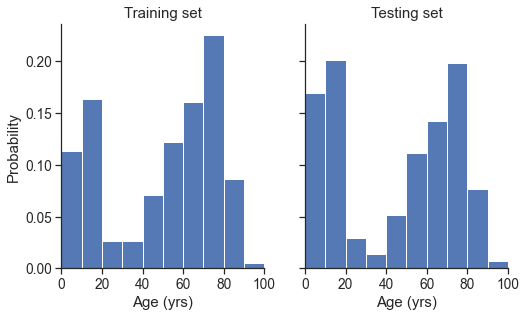

In [10]:
display(df_demo.groupby(['set', 'dataset'])['age'].agg(['mean', 'std', 'min', 'max']).round(2))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharey=True, sharex=True)
sns.histplot(df_demo[df_demo['set'] == 'training']['age'], 
             bins=np.linspace(0, 100, 11), stat='probability', alpha=0.95, ax=ax1)
sns.histplot(df_demo[df_demo['set'] == 'testing']['age'], 
             bins=np.linspace(0, 100, 11), stat='probability', alpha=0.95, ax=ax2)

ax1.set_xlabel("Age (yrs)")
ax2.set_xlabel("Age (yrs)")

ax1.set_title("Training set")
ax2.set_title("Testing set")

plt.xlim(0, 100)
plt.xticks([0, 20, 40, 60, 80, 100])

sns.despine()

plt.savefig(outdir + "hist_age.png", dpi=300, bbox_inches="tight")

#### AHI

In [11]:
df_demo.groupby(['set', 'dataset'])['ahi'].agg(['mean', 'std', 'min', 'max']).round(2)

mean    std   min     max
set      dataset                            
testing  CCSHS     1.35   2.63  0.00   19.49
         CFS      10.65  16.99  0.00  102.65
         CHAT      6.88   5.55  1.40   29.33
         MESA     21.93  20.18  0.00  110.33
         MROS     17.41  14.35  0.00   71.00
         SHHS     14.57  12.28  0.18   59.40
training CCSHS     1.48   5.23  0.00   99.13
         CFS      13.44  20.65  0.00  125.07
         CHAT      6.76   5.84  0.17   32.43
         HOMEPAP  15.99  19.93  0.32   90.20
         MESA     19.24  18.09  0.00  111.28
         MROS     16.80  14.95  0.00   76.00
         SHHS     13.90  14.63  0.00   70.89

### Categorical variables

In [12]:
def value_counts_chi2(dv, normalize=True):
    """Show value counts and chi-square test.
    
    NaN values are droppped by chi2_independence (see pd.crosstab)"""
    if normalize:
        display(100 * grp_set[dv].value_counts(normalize=normalize, sort=False).round(5))
    else:
        display(grp_set[dv].value_counts(sort=False).round(5))
    print("")
    display(pg.chi2_independence(df_demo, x=dv, y='set', correction=True)[2].iloc[0, :])

In [13]:
# Sex and chi2-test
value_counts_chi2("male")

set       male
testing   0       44.615
          1       55.385
training  0       43.440
          1       56.560
Name: male, dtype: float64

test       pearson
lambda         1.0
chi2      0.231695
dof            1.0
pval       0.63027
cramer    0.007862
power     0.076938
Name: 0, dtype: object

In [14]:
# Ethnicity
value_counts_chi2("ethnicity")

set       ethnicity
testing   african      29.231
          caucasian    58.462
          hispanic      6.838
          other         5.470
training  african      29.466
          caucasian    57.920
          hispanic      7.240
          other         5.375
Name: ethnicity, dtype: float64

test       pearson
lambda         1.0
chi2      0.153949
dof            3.0
pval      0.984657
cramer    0.006409
power     0.059178
Name: 0, dtype: object

In [15]:
# Dataset
value_counts_chi2("dataset")

set       dataset
testing   CCSHS      17.094
          CFS        16.923
          CHAT       17.094
          MESA       16.581
          MROS       15.385
          SHHS       16.923
training  CCSHS      13.089
          CFS        18.527
          CHAT       11.097
          HOMEPAP     2.592
          MESA       18.179
          MROS       17.863
          SHHS       18.653
Name: dataset, dtype: float64

/Users/raphael/GitHub/pingouin/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/scipy/stats/stats.py:6713: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


test        pearson
lambda          1.0
chi2      39.632152
dof             6.0
pval       0.000001
cramer     0.102831
power      0.999469
Name: 0, dtype: object

In [16]:
grp_set['dataset'].value_counts()

set       dataset
testing   CCSHS      100
          CHAT       100
          CFS         99
          SHHS        99
          MESA        97
          MROS        90
training  SHHS       590
          CFS        586
          MESA       575
          MROS       565
          CCSHS      414
          CHAT       351
          HOMEPAP     82
Name: dataset, dtype: int64

In [17]:
# Apnea severity
value_counts_chi2("apnea")

set               
testing   None        43.761
          Mild        27.179
          Moderate    18.120
          Severe      10.940
training  None        42.776
          Mild        27.790
          Moderate    17.325
          Severe      12.109
Name: apnea, dtype: float64

test       pearson
lambda         1.0
chi2      0.921804
dof            3.0
pval      0.820163
cramer    0.015683
power     0.110061
Name: 0, dtype: object

In [18]:
# Insomnia
value_counts_chi2("insomnia")

set       insomnia
testing   0.0         95.500
          1.0          4.500
training  0.0         93.049
          1.0          6.951
Name: insomnia, dtype: float64

test       pearson
lambda         1.0
chi2      1.296056
dof            1.0
pval      0.254935
cramer    0.018596
power     0.206648
Name: 0, dtype: object

In [19]:
# Narcolepsy
value_counts_chi2("narcolepsy")

set       narcolepsy
testing   0.0           100.000
training  0.0            99.169
          1.0             0.831
Name: narcolepsy, dtype: float64

/Users/raphael/GitHub/pingouin/pingouin/contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))


test       pearson
lambda         1.0
chi2      0.081892
dof            1.0
pval      0.774749
cramer    0.004674
power     0.059433
Name: 0, dtype: object

In [20]:
# Depression
value_counts_chi2("depression")

set       depression
testing   0.0           86.842
          1.0           13.158
training  0.0           84.171
          1.0           15.829
Name: depression, dtype: float64

test       pearson
lambda         1.0
chi2      0.688042
dof            1.0
pval      0.406831
cramer    0.013549
power     0.131777
Name: 0, dtype: object

In [21]:
# Diabetes
value_counts_chi2("diabete")

set       diabete
testing   0.0        82.008
          1.0        17.992
training  0.0        84.184
          1.0        15.816
Name: diabete, dtype: float64

test       pearson
lambda         1.0
chi2      1.268897
dof            1.0
pval      0.259974
cramer      0.0184
power     0.203291
Name: 0, dtype: object

In [22]:
# Hypertension
value_counts_chi2("hypertension")

set       hypertension
testing   0.0             64.730
          1.0             35.270
training  0.0             61.171
          1.0             38.829
Name: hypertension, dtype: float64

test       pearson
lambda         1.0
chi2      2.054545
dof            1.0
pval      0.151753
cramer    0.023413
power     0.299582
Name: 0, dtype: object